In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from itables import show
import numpy as np

%matplotlib inline

There are a lot of data in the dataset. Deep analysis of all of them will require very much time. So we gave ourself a task and will try to say which course is **the easiest, the hardest and the most popular.** To answer it we'll deepen into students and assesments data.

Agenda:
- motivation
- data overview
- student's data overview
- courses popularity 
- repetitions
- credits
- students' results
- assesments
- assesments grades

# Motivation

The motivation for this analysis is to improve the educational outcomes of universities. After careful analysis of the collected data, it is planned to discover which subjects are the most difficult for students. Knowing these subjects will allow individual assistance in preparing for them and learning them. What's more, this will give students more information when choosing courses and allow them to manage their time more consciously. In addition, it is also a support for teachers, who will be aware of the difficulty of the subjects they teach.

## Data

First we'll load data and see the overall picture of it.

In [53]:
students_df = pd.read_csv('data/studentInfo.csv')
assesments = pd.read_csv('data/assessments.csv')
student_assesments = pd.read_csv('data/studentAssessment.csv')

In [54]:
students_df.head(3)
# assesments.head(3)
# student_assesments.head(3)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn


We have data from various files:
- studentInfo -- data about students, courses they took and their final results
- assesments -- all assesments for course with their due dates and weight
- studentAssesment -- when the student submitted the assesment, if it is banked and how was it scored. 

## Students info

At first we'll focus on the information about courses taken by students.

In [55]:
students_df["code_presentation"].value_counts()

2014J    11260
2013J     8845
2014B     7804
2013B     4684
Name: code_presentation, dtype: int64

In [56]:
students_df.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

In [57]:
ProfileReport(students_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In StudentsInfo we have data for 4 semesters of years 2013 and 2014. Most of the data is complete, only imd_band has 1111 null values. Imd band specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.

Most features show hardly no correlation. Only gender and code module seems to be correated. It can mean that women chose different courses than men, but it's too low correlation to be sure about it.

In [58]:
# How many ids are repeated in db
sum(students_df.value_counts("id_student")>1)

3538

In [59]:
# create unique id
students_df["id_student_course"] = students_df["id_student"].astype(str) + students_df["code_module"] + students_df["code_presentation"]
students_df.value_counts("id_student_course")[:2]

id_student_course
100064FFF2013J    1
603921GGG2014B    1
dtype: int64

Some of the students took multiple courses or repeated the course so student_id is not unique. Students id, code module and code presentation together create unique value.

Text(0.5, 1.0, 'Courses popularity')

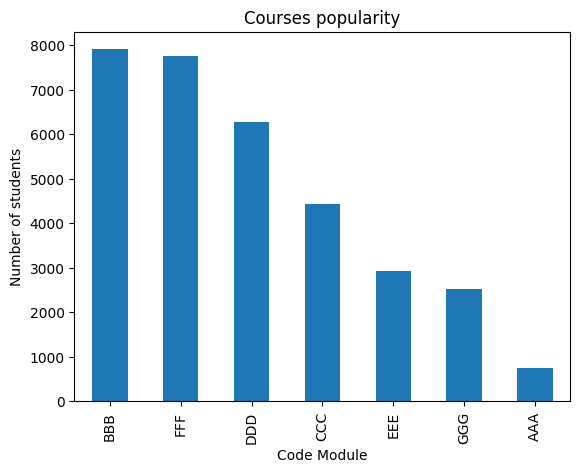

In [60]:
# how many students took each course
course_group = students_df.groupby("code_module")
students_by_module = course_group.count()["id_student"].sort_values(ascending=False)
students_by_module.plot.bar()
plt.xlabel("Code Module")
plt.ylabel("Number of students")
plt.title("Courses popularity")

The most popular courses were BBB and FFF with over 7700 students. The least popular course was AAA with 748 students. But **did the students choose the least difficult or most difficult subjects?**

### Repetitions by course

To answer this we'll firstly take look at students repeating the course. The relation is simple – if the subject was difficult, it is more likely that many students had to repeat it.

In [61]:
repetitions = course_group["num_of_prev_attempts"].value_counts().rename("num_of_students").reset_index()
repetitions = repetitions[repetitions["num_of_prev_attempts"] > 0]
repetitions

,code_module,num_of_prev_attempts,num_of_students
1,AAA,1,41
3,BBB,1,897
4,BBB,2,235
5,BBB,3,64
6,BBB,4,16
7,BBB,5,8
8,BBB,6,1
10,CCC,1,235
12,DDD,1,924
13,DDD,2,218


In [62]:
repetitions_by_module = repetitions.groupby("code_module").sum()["num_of_students"].sort_values(ascending=False)
repetitions_by_module

code_module
FFF    1244
BBB    1221
DDD    1199
CCC     235
EEE     149
GGG      83
AAA      41
Name: num_of_students, dtype: int64

Text(0.5, 1.0, 'Repetitions by course')

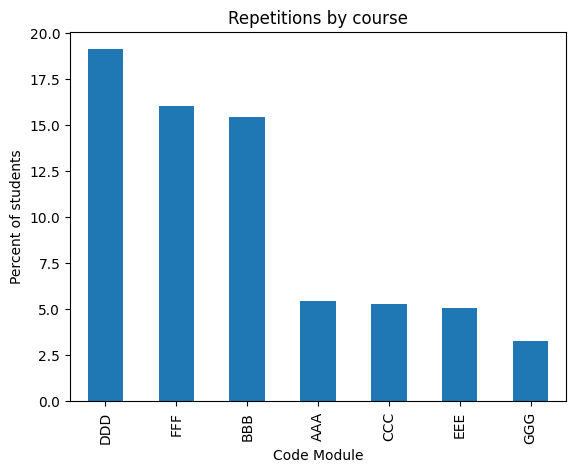

In [63]:
repetitions_percent = (repetitions_by_module/students_by_module * 100).sort_values(ascending=False)
repetitions_percent.plot.bar()
plt.xlabel("Code Module")
plt.ylabel("Percent of students")
plt.title("Repetitions by course")

The highest percentage of the students taking the course retook course DDD – 1199 which is 19% of the participants. Among them 924 repeated it once, 218 – twice, 39 – 3 times, 13 – 4 times, 3 – 5 times and 2 – 6 times! FFF and BBB were also difficult, with more than 1000 students repeating them.
The least percentage of retakes were in the courses EE and GGG.

In [64]:
# how many students repeated the course based on students we have in database
student_repeated_course = students_df.groupby(["code_module", "id_student"]).count()["code_presentation"]
(student_repeated_course > 1).droplevel(1).groupby("code_module").sum().sort_values(ascending=False)

code_module
DDD    409
FFF    351
BBB    209
CCC    183
EEE     74
AAA     36
GGG      9
Name: code_presentation, dtype: int64

In [65]:
student_repeated_course[student_repeated_course > 1].droplevel(1).groupby("code_module").value_counts()

code_module  code_presentation
AAA          2                     36
BBB          2                    202
             3                      6
             4                      1
CCC          2                    183
DDD          2                    395
             3                     13
             4                      1
EEE          2                     73
             3                      1
FFF          2                    337
             3                     14
GGG          2                      9
Name: code_presentation, dtype: int64

We've also checked that not all repetitions are included in the dataset. The reason is probably that we have only data from 2 years and its not possible for someone to repeat the course 6 times during 4 semesters.

### Studied credits

Number of studied credits can tell us on which year of studies is the course. Higher years are more likely to have more difficult courses, but on the first year students are not so well prepared to learn and the level is not equal. It is possible, that students from lover years may need more help.

/tmp/ipykernel_12622/581536312.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  credits = course_group.mean()["studied_credits"].sort_values(ascending=False)


Text(0.5, 1.0, 'Credits by course')

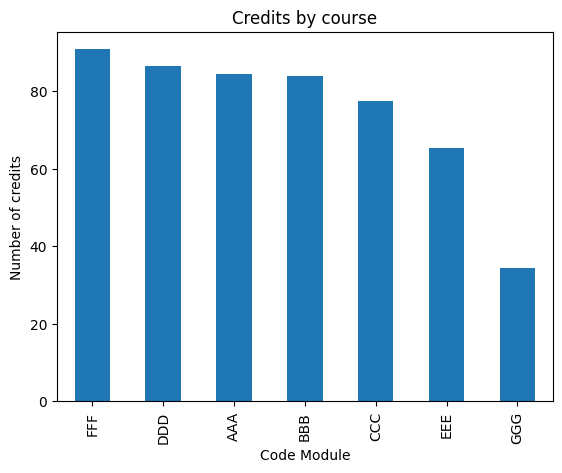

In [66]:
credits = course_group.mean()["studied_credits"].sort_values(ascending=False)
credits.plot.bar()
plt.xlabel("Code Module")
plt.ylabel("Number of credits")
plt.title("Credits by course")

The lowest average number of credits was needed for GGG – 34 credits. The highest for FFF – 90 credits and DDD – 86. These courses were probably taken by the students of higher years. That means the university authorities should pay attention to course GGG, because there are many students with low study experience there. Moreover, the teachers should be less demanding on course GGG than FFF.

### Results

The one of the most important cases is also the result of the students. If not many students passed the course, it is likely that the course was  difficult.

In [67]:
result_counts = course_group["final_result"].value_counts()
result_counts_percent = round(result_counts/ students_by_module * 100, 2).unstack()
result_counts_percent

final_result,Distinction,Fail,Pass,Withdrawn
code_module,,,,
AAA,5.88,12.17,65.11,16.84
BBB,8.56,22.34,38.91,30.19
CCC,11.23,17.61,26.61,44.54
DDD,6.11,22.51,35.51,35.87
EEE,12.13,19.15,44.10,24.61
FFF,8.63,22.04,38.37,30.96
GGG,15.63,28.73,44.12,11.52


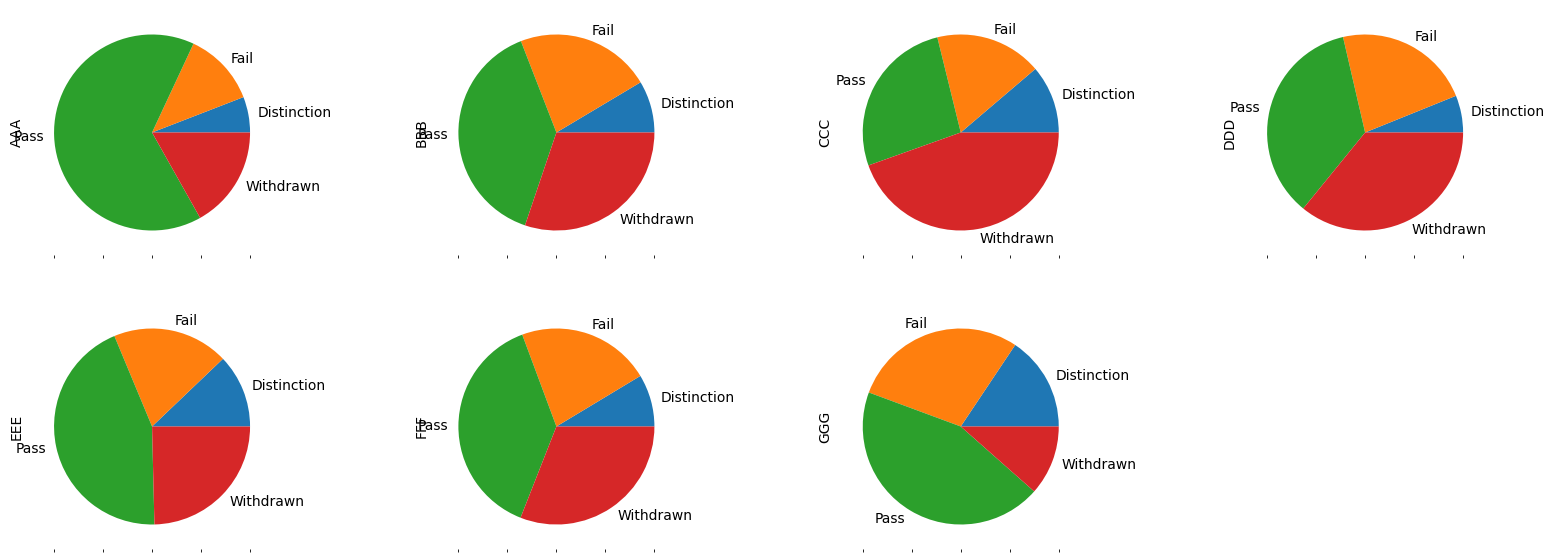

In [117]:
axs = result_counts_percent.T.plot.pie(subplots=True, legend=False, figsize=(20, 7), layout=(2, -1))

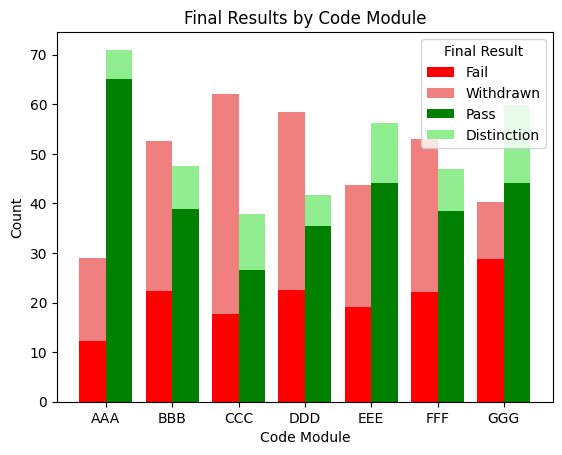

In [69]:
X_axis = np.arange(len(result_counts_percent.index)) 

plt.bar(X_axis - 0.2, result_counts_percent["Fail"],  width=0.4, label = "Fail", color="red")
plt.bar(X_axis - 0.2, result_counts_percent["Withdrawn"], width=0.4, bottom = result_counts_percent["Fail"], label="Withdrawn", color="lightcoral")

plt.bar(X_axis + 0.2, result_counts_percent["Pass"],  width=0.4, label = "Pass", color="green")
plt.bar(X_axis + 0.2, result_counts_percent["Distinction"], width=0.4, bottom = result_counts_percent["Pass"], label="Distinction", color="lightgreen")

plt.xticks(X_axis, result_counts_percent.index) 
plt.xlabel("Code Module")
plt.ylabel("Count")
plt.title("Final Results by Code Module")
plt.legend(title="Final Result", loc="upper right")

plt.show()

The course AAA was passed by over 70% of the students including 5% with distinction. It was one of the highest scores. Based on this we can say it was a very easy course. On the other side we have courses CCC, DDD nad FFF, where more students failes or withdrown than passed, so they seem difficult. In the course CCC many students withdrawn but from the ones who stayed, most of them passed. The highest fail number was in course GGG.

### Summary

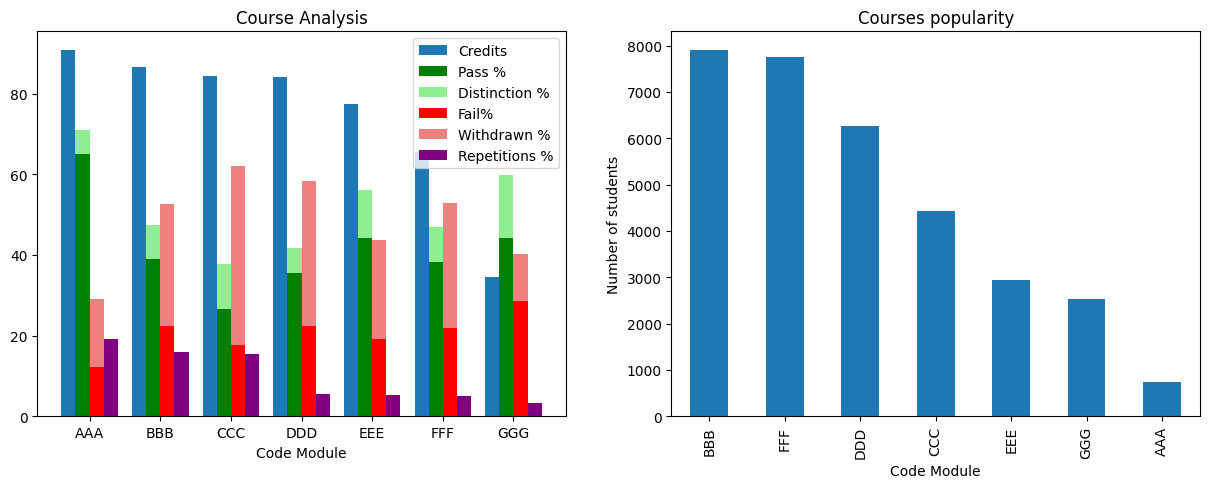

In [70]:
f, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1,2,1)
repetitions_percent
credits_percent = credits/max(credits)*100
good_score_percent = result_counts_percent["Pass"] + result_counts_percent["Distinction"]
bad_score_percent = result_counts_percent["Fail"] + result_counts_percent["Withdrawn"]

X_axis = np.arange(len(result_counts_percent.index)) 

plt.bar(X_axis - 0.3, credits, width=0.2, label="Credits")
plt.bar(X_axis - 0.1, result_counts_percent["Pass"], width=0.2, label="Pass %", color="green")
plt.bar(X_axis - 0.1, result_counts_percent["Distinction"], bottom=result_counts_percent["Pass"], width=0.2, label="Distinction %", color="lightgreen")
plt.bar(X_axis + 0.1, result_counts_percent["Fail"],  width=0.2, label = "Fail%", color="red")
plt.bar(X_axis + 0.1, result_counts_percent["Withdrawn"], bottom=result_counts_percent["Fail"],  width=0.2, label = "Withdrawn %", color="lightcoral")
plt.bar(X_axis + 0.3, repetitions_percent,  width=0.2, label = "Repetitions %", color="purple")

plt.xticks(X_axis, result_counts_percent.index) 
plt.xlabel("Code Module")
plt.title("Course Analysis")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
students_by_module.plot.bar()
plt.xlabel("Code Module")
plt.ylabel("Number of students")
plt.title("Courses popularity")

plt.show()

Summing up all we analysed to this point, course AAA looks quite easy. It required the most of credits, but a lot of the students passed, however, this couse was not choosen by many students. Maybe it's chosen by experienced students who are aware of their choice. They know what will be expected from them and what knowledge they will need.

In courses FFF, CCC and DDD many students resigned, so the results aren't appealing. Moreover, course C had high repetition rate. It's hard to make conclusions about resignations, we as analytics can't answer this question. We can, hovewer, detect such courses and comunicate them to the university authorities, so they can take further steps.

Course GGG seems to be difficult. It has the highest fail rate and was not popular among students, picked mostly by this with low credits number. Our a priori beliefs to take care of students from course GGG were right. It seems to be a big dissproportion between them. They seems motivated to learn, because ther withdrawn rate is low, but many of them still don't pass, while some pass even with distinction.

## Assessments

### Data analysis

Now we'll take look on the assignments. We'll see how many of them were in each course, how many students submitted them and what were the scores and delays. Many tasks usually means course requiring a lot of work, sometimes after deadline if the task is really hard, but to confirm it we'll also look at the scores.

In [71]:
assesments.head(3)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0


In [72]:
student_assesments.head(3)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0


In [73]:
student_assesments.score.min(), student_assesments.score.max()

(0.0, 100.0)

In [74]:
print(student_assesments.isna().sum())
student_assesments["score"] = student_assesments["score"].fillna(0)

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64


In [75]:
assesments.weight.min(), assesments.weight.max()

(0.0, 100.0)

In [76]:
assesments["date"].max()

261.0

In [77]:
print(assesments.isna().sum())
assesments["date"] = assesments["date"].fillna(10000)

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64


Every assesment was graded between 0 and 100 and has a weight between 0 and 100. It could also be banked. We have 173 students with not scored assesment and 11 assigments without a date. We graded the unholded papers to 0 and made a duedate very big for assesments without it.

### Assesments statistics

To analyze it further we need to join data about assesments and students' submitions.

In [78]:
assesments_results = student_assesments.merge(assesments, on="id_assessment", how="left")
assesments_results["weighted_score"] = assesments_results["score"] * assesments_results["weight"]
assesments_results.head(3)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,weighted_score
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,780.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,700.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,720.0


In [79]:
number_of_semesters = assesments_results.groupby("code_module")["code_presentation"].unique().apply(lambda x: len(x))

assesments_by_course = (assesments.groupby("code_module").count()["id_assessment"]/number_of_semesters).sort_values(ascending=False)
assesments_by_course = pd.DataFrame(assesments_by_course, columns=["assesments_per_semester"])

assesments_by_course["mean_weight"] = assesments.groupby("code_module")["weight"].mean()
assesments_by_course["min_weight"] = assesments.groupby("code_module")["weight"].min()
assesments_by_course["max_weight"] = assesments.groupby("code_module")["weight"].max()

show(assesments_by_course)


Some of the courses took place on more semesters than others so we averaged the numbers of task for a semester. The most number of tasks were given in the module FFF – 13. The least in AAA – 6 and EEE – 5. The highest weights were assigned to EEE nad AAA tasks. So these courses had little, but highly graded tasks. For BBB, FFF and GGG there were some assignments with 0 weight.

In course CCC the high amount of highly weighted tasks may be one of the reasons why students withdrawn and repeated the course so frequently.

We believe that many quite easy and low rated tasks are better, because they motivate to work systematically and don't put so much pressure on one task. Data shows that such courses are not always the easiest ones, but anyway, this strategy seems reasonable.

In [80]:
assesment_group = assesments_results.groupby(["code_module", "id_assessment"])
assesments_results["days_to_deadline"] = assesments_results["date"] - assesments_results["date_submitted"]
assesments_results["after_deadline"] = assesments_results["days_to_deadline"] < 0

avg_submitions_per_task = assesment_group.count()["id_student"].groupby("code_module").mean()
assesments_by_course["avg_submitions_per_task_percent"] = avg_submitions_per_task/(students_by_module/number_of_semesters) * 100

assesments_by_course["avg_task_score"] = assesment_group["score"].mean().groupby("code_module").mean()

avg_submitions_after_deadline = assesment_group["after_deadline"].sum().groupby("code_module").mean()
assesments_by_course["avg_submitions_after_deadline_percent"]  = avg_submitions_after_deadline/avg_submitions_per_task * 100

show(assesments_by_course)

From the data we can tell that submition rate is rather low. For the course CCC only 47% af the students submitted the task (on average). For the rest of the courses this rate is about 56-67% with an exception at course AAA with 84%. There were also many submitions after deadline. In the course CCC almost 59% of the submitions were late. Remembering that there were also not so many submitions makes it even worse. The lowest after-deadline submition rate were on courses FFF and GGG – around 10% of submitions.

On the other hand, the scores were rather high, with the average above 69 for almost all courses. They were the highest for courses EEE and GGG – 80 pts. The lowest ones were AAA and DDD – around 69.

Our previous beliefs that experienced students from AAA knows what they will need to do are confirmed here, because they mostly submit te task.

In course GGG, chosen by less experienced students we have low submitions, but with high grades. It brings us to the conclusions, that thy may submit only the tasks they are happy about, taking them chance to improve on their mistakes.

### Students' results

To see which course's assignments were the hardest we'll look at students' results.

In [81]:
total_weights_for_sems = assesments.groupby(["code_module", "code_presentation"])["weight"].sum()

students_grades = assesments_results.groupby(["code_module", "code_presentation", "id_student"])["weighted_score"].sum()/total_weights_for_sems

students_grades = students_grades.groupby(["code_module", "code_presentation"]).aggregate([np.mean, np.min, np.max, np.std, np.median])

show(students_grades, "students' averages", dom="tl")

In [82]:
assesments_results[assesments_results["code_module"] == "GGG"]["score"].value_counts().head(3)

100.0    5332
80.0     3024
60.0     1470
Name: score, dtype: int64

In [83]:
assesments_results[assesments_results["code_module"] == "GGG"]["weight"].value_counts()

0.0    15219
Name: weight, dtype: int64

We counted a weighted average for all students existing in datafiles. Almost in all courses the lowest average was 0. That probably corresponds to students who dropped out or failed. The highest mean – 39-48 belonged to course DDD. In this course were also students with scores higher than 95. Other courses have mean scores between 24 and 34, with the highest rather between 45 and 50. Only on course CCC the highest score was a bit more – 66. Course GGG is a real exception, with all scores equal to 0. In this course there were only 5 null values replaced by 0 so they're not the cause of the problem. The reason is that even if the students get quite high scores for the tasks, they submitted only the tasks with weight equal to 0.

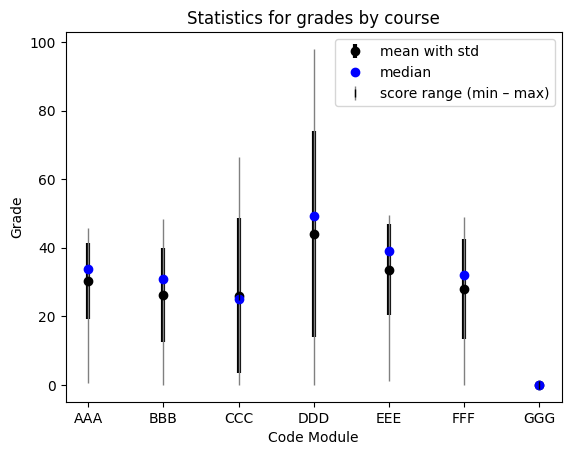

In [84]:
grades_by_course = students_grades.groupby("code_module").mean()

X = np.arange(len(grades_by_course.index))

plt.errorbar(X, grades_by_course["mean"], grades_by_course["std"], fmt='ok', lw=3, label='mean with std')
plt.errorbar(X, grades_by_course["median"], fmt='ob', lw=3, label='median')

plt.errorbar(X, grades_by_course["mean"], [grades_by_course["mean"] - grades_by_course["amin"], grades_by_course["amax"] - grades_by_course["mean"]],
             fmt='|k', ecolor='gray', lw=1, label='score range (min – max)')

xticks = plt.xticks(X, grades_by_course.index)
plt.xlabel("Code Module")
plt.ylabel("Grade")
plt.title("Statistics for grades by course")
plt.legend(loc="upper right")

Looking at this plot, we can tell that course DDD was the easiest to obtain high score. The second was CCC, however the mean and median were low here. Other courses were rather difficult, with all students achievving scire below 50%. We don't look on GGG because of the weights of tasks.

Results from the grade analysis are rather contrary to the ones from courses. For the course A with rather low grades, the passing rate was very very high. For the course D with high grades, the passing rate was rather low. The course G also has a great amount of fails, but not many withdrawns and more students passes than failed. 

According to this it's hard to determine which course was the easiest. According to pass rate we'd say AAA was easy, but looking at assignment scores, the ones from DDD were for sure easier.

There may be some reasons for this dichotomy. Firstly, we don't have grading rules for the courses. They might be graded for something that is not on the platform – oral or paper exam, activity during classes, etc. The assignments are only part of the picture. We also assumed for all courses you need 50% to pass. This may be wrong. We can have missing data about submitions too. Students could simply send some of them by mail by mistake or system error. 

---


### Other

We've also try other stuff, but they were not so interesting in terms of our question.

In [85]:
clicks_df = pd.read_csv('data/studentVle.csv')

In [86]:
# correlation between final result and other variables

import seaborn as sns

# code finalresult 
# students_df['final_result'].value_counts().plot(kind='bar')
student_clicks = clicks_df.groupby("id_student").sum()["sum_click"]
students_df = pd.merge(students_df, student_clicks, on="id_student")

students_df["final_result_coded"] = students_df["final_result"].map({"Pass": 1, "Fail": -1, "Distinction": 2, "Withdrawn": 0})
students_df.corr()["final_result_coded"].drop("id_student").sort_values()


/tmp/ipykernel_12622/225468443.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  student_clicks = clicks_df.groupby("id_student").sum()["sum_click"]
/tmp/ipykernel_12622/225468443.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  students_df.corr()["final_result_coded"].drop("id_student").sort_values()


num_of_prev_attempts   -0.124351
studied_credits        -0.072336
sum_click               0.365557
final_result_coded      1.000000
Name: final_result_coded, dtype: float64

/tmp/ipykernel_12622/1618666189.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(students_df.corr())


<Axes: >

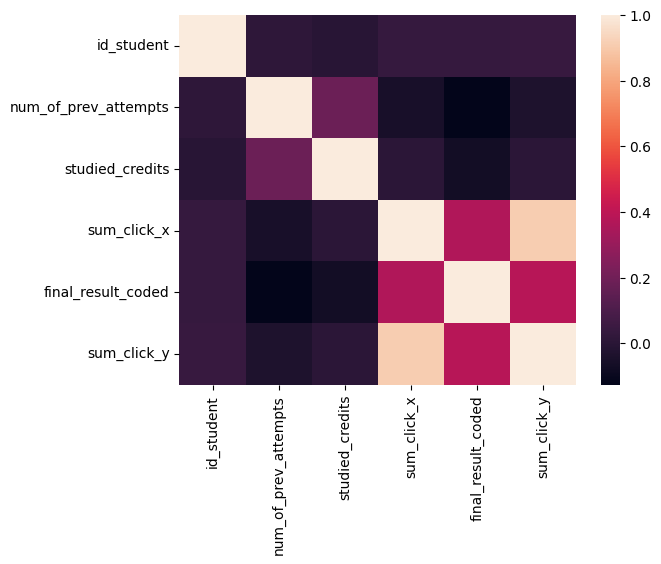

In [118]:
sns.heatmap(students_df.corr())

In [87]:
# add clicks for student by module

student_clicks = clicks_df.groupby(["id_student", "code_module"]).sum()["sum_click"]
students_df = pd.merge(students_df, student_clicks, on=["id_student", "code_module"])

# students_df[students_df.id_student == 584077]

students_df["final_result_coded"] = students_df["final_result"].map({"Pass": 1, "Fail": -1, "Distinction": 2, "Withdrawn": 0})
# students_df.corr()["final_result_coded"].drop("id_student").sort_values()

/tmp/ipykernel_12622/533846528.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  student_clicks = clicks_df.groupby(["id_student", "code_module"]).sum()["sum_click"]


In [88]:
modules_group = students_df.groupby("code_module")
modules_group.count()

,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,id_student_course,sum_click_x,final_result_coded,sum_click_y
code_module,,,,,,,,,,,,,,,
AAA,737,737,737,737,737,714,737,737,737,737,737,737,737,737,737
BBB,6682,6682,6682,6682,6682,6626,6682,6682,6682,6682,6682,6682,6682,6682,6682
CCC,4034,4034,4034,4034,4034,3793,4034,4034,4034,4034,4034,4034,4034,4034,4034
DDD,5822,5822,5822,5822,5822,5551,5822,5822,5822,5822,5822,5822,5822,5822,5822
EEE,2702,2702,2702,2702,2702,2590,2702,2702,2702,2702,2702,2702,2702,2702,2702
FFF,7156,7156,7156,7156,7156,6805,7156,7156,7156,7156,7156,7156,7156,7156,7156
GGG,2368,2368,2368,2368,2368,2361,2368,2368,2368,2368,2368,2368,2368,2368,2368


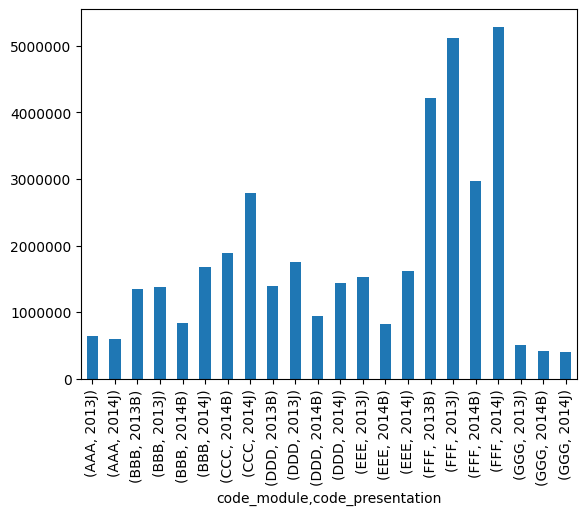

In [89]:

clicks_df.groupby(['code_module', 'code_presentation']).sum()["sum_click"].plot(kind='bar')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()

<Axes: xlabel='date'>

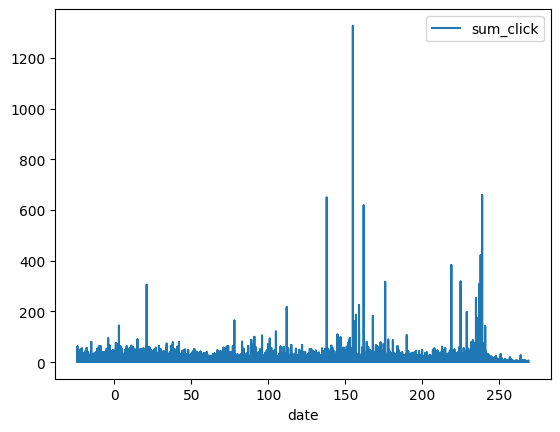

In [90]:
clicks_df[clicks_df["code_module"] == "AAA"].plot(x="date", y="sum_click")